In [1]:
import torch
import pickle
import random
from tqdm import tqdm

In [2]:
import transformers

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

In [4]:
import os
from torchvision import models
from torch import nn as nn


In [5]:
from PIL import Image
from PIL import Image
import requests
from io import BytesIO


In [6]:
import torchvision.transforms as transforms
from torch.autograd import Variable

In [7]:
import torch
from transformers import AutoTokenizer, AutoModel

In [8]:
agent_to_code = {}
agent_to_code['humans'] = 'a'
agent_to_code['azure'] = 'b'
agent_to_code['histogram'] = 'c'
agent_to_code['google'] = 'd'

code_to_agent = {}
code_to_agent['a'] = 'humans'
code_to_agent['b'] = 'azure'
code_to_agent['c'] = 'histogram'
code_to_agent['d'] = 'google'

In [9]:
from google.colab import drive
drive.mount('/content/drive')
ROOT='''/content/drive/MyDrive/Colab Notebooks/googledrive/r3-ColorWordOnly'''

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# impath = "static/dataset/coco_val_set/%s.jpg"%fp.split('/')[-1].split('_')[0]

In [10]:
with open(ROOT+'/color_to_bert.p','rb') as F:
    color_to_embedding = pickle.load(F)

In [17]:
! unzip "/content/drive/MyDrive/Colab Notebooks/googledrive/colorDetection/Feedback_Color/static/responses_color.zip" -d "/content/drive/MyDrive/Colab Notebooks/googledrive/r3-ColorWordOnly/"

Archive:  /content/drive/MyDrive/Colab Notebooks/googledrive/colorDetection/Feedback_Color/static/responses_color.zip
   creating: /content/drive/MyDrive/Colab Notebooks/googledrive/r3-ColorWordOnly/responses_color/
  inflating: /content/drive/MyDrive/Colab Notebooks/googledrive/r3-ColorWordOnly/responses_color/1017_e_0.html  
  inflating: /content/drive/MyDrive/Colab Notebooks/googledrive/r3-ColorWordOnly/responses_color/431_a_0.html  
  inflating: /content/drive/MyDrive/Colab Notebooks/googledrive/r3-ColorWordOnly/responses_color/494_b_0.html  
  inflating: /content/drive/MyDrive/Colab Notebooks/googledrive/r3-ColorWordOnly/responses_color/805_b_0.html  
  inflating: /content/drive/MyDrive/Colab Notebooks/googledrive/r3-ColorWordOnly/responses_color/302_a_0.html  
  inflating: /content/drive/MyDrive/Colab Notebooks/googledrive/r3-ColorWordOnly/responses_color/691_c_0.html  
  inflating: /content/drive/MyDrive/Colab Notebooks/googledrive/r3-ColorWordOnly/responses_color/310_d_0.html  

In [22]:
! unzip "/content/drive/MyDrive/Colab Notebooks/googledrive/r3-ColorWordOnly/image_embeddings.zip" -d "/content/drive/MyDrive/Colab Notebooks/googledrive/r3-ColorWordOnly/"

Archive:  /content/drive/MyDrive/Colab Notebooks/googledrive/r3-ColorWordOnly/image_embeddings.zip
   creating: /content/drive/MyDrive/Colab Notebooks/googledrive/r3-ColorWordOnly/image_embeddings/
  inflating: /content/drive/MyDrive/Colab Notebooks/googledrive/r3-ColorWordOnly/__MACOSX/._image_embeddings  
  inflating: /content/drive/MyDrive/Colab Notebooks/googledrive/r3-ColorWordOnly/image_embeddings/604.p  
  inflating: /content/drive/MyDrive/Colab Notebooks/googledrive/r3-ColorWordOnly/__MACOSX/image_embeddings/._604.p  
  inflating: /content/drive/MyDrive/Colab Notebooks/googledrive/r3-ColorWordOnly/image_embeddings/250.p  
  inflating: /content/drive/MyDrive/Colab Notebooks/googledrive/r3-ColorWordOnly/__MACOSX/image_embeddings/._250.p  
  inflating: /content/drive/MyDrive/Colab Notebooks/googledrive/r3-ColorWordOnly/image_embeddings/314.p  
  inflating: /content/drive/MyDrive/Colab Notebooks/googledrive/r3-ColorWordOnly/__MACOSX/image_embeddings/._314.p  
  inflating: /content/

In [11]:
color_to_embedding['none'] = color_to_embedding['white']

In [12]:
resnet_18 = models.resnet18(pretrained=True)
feature_model = nn.Sequential(*list(resnet_18.children())[:-1])
feature_model.eval();
feature_model_5th_layer = nn.Sequential(*list(resnet_18.children())[:5])
feature_model_5th_layer.eval()
scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
def get_image_embedding(url,mode='fullmodel'):
    if mode == 'fullmodel':
      with open(ROOT+'/image_embeddings/'+url.split('/')[-1].split('.')[0]+'.p', 'rb') as f:
        final_embedding = pickle.load(f)
    else:
      response = requests.get(url)
      img = Image.open(BytesIO(response.content)).convert('RGB')

      # img = Image.open(impath).convert('RGB')
      t_img = Variable(normalize(to_tensor(scaler(img))).unsqueeze(0))
      if mode=='5th':
        img_embedding = feature_model_5th_layer(t_img)
        final_embedding = img_embedding.squeeze(0).mean(0).flatten()
      else:
        img_embedding = feature_model(t_img)
        final_embedding = img_embedding[0,:,0,0]
    return final_embedding



In [ ]:
# impath_to_embeddings = {}
# for htmlname in tqdm(os.listdir('static/responses_color/')):
#     imname = htmlname.split('_')[0]
#     impath = "static/dataset/coco_val_set/%s.jpg"%imname
#     if not impath in impath_to_embeddings.keys():
#         im_embedding = get_image_embedding(impath)
#         impath_to_embeddings[impath] = 'done'
#         with open('image_embeddings/%s.p'%imname,'wb') as F:
#             pickle.dump(im_embedding,F)

In [ ]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
# model = AutoModel.from_pretrained("distilbert-base-uncased").to(device)

In [ ]:
# import os
# os.mkdir('image_embeddings')

In [ ]:
# with open('impath_to_embeddings.p','rb') as F:
#     impath_to_embeddings = pickle.load(F)

In [19]:
def read_data(allowed_algorithms = ['azure','histogram','google']):
    human_data = []
    ai_data = {}

    for file in os.listdir(ROOT+'/responses_color/'):
        fp = ROOT+"/responses_color/%s"%file
        if fp.endswith('html'):
            if fp.split('_')[2] == 'e': # catch trial
                continue
            with open(fp,'r') as F:
                contents = F.readlines()

                color = contents[0].split(': ')[2].split('<')[0]

                speaker_type = code_to_agent[fp.split('_')[2]]

                impath = "https://xiaoturing.s3.us-east-1.amazonaws.com/color_det/%s.jpg"%fp.split('/')[-1].split('_')[0]
            if speaker_type == 'humans':
                human_data.append([impath,color,speaker_type])
            else:
                if speaker_type in allowed_algorithms:
                    ai_data.setdefault(speaker_type,[]).append([impath,color,speaker_type])
    return human_data, ai_data
human_data, ai_data = read_data()

In [ ]:
url_to_embeddings = {}
for url, _, _ in human_data:
  if url not in url_to_embeddings:
    url_to_embeddings[url] = get_image_embedding(url,'5th')
with open(ROOT+"/url_to_embeddings_5th_layer.pickle", 'wb') as f:
  pickle.dump(url_to_embeddings,f)

In [28]:
from sklearn import svm

import json
import numpy as np



modelname_dict = {'catch':'CatchTrial','azure':'Azure','histogram':'Histogram','google':'Google'}
label_dict = {'human':0,'machine':1,'Human':0,'Machine':1,'azure':1,'histogram':1,'google':1,'catch':1}
def construct_confmat():
    labels = ['h_azure','h_histogram','h_google']#,'h_catch']
    confmatrices = {**{'h_machine':np.zeros((2,2))}, **{label: np.zeros((1,2)) for label in labels}}
    return confmatrices




for model in ai_data.keys():
  random.shuffle(ai_data[model])

for mode in ['fullmodel','5th','bertonly']:

  ai_judge = {}
  trialnum = 0
  confmat_overall_AI = construct_confmat()
  for run_no,seed in enumerate([42,4343,666,0,4242]):
    ### ===================== split data ======================== ###
    X_train, y_train, X_test, y_test = [], [], [], []
    test_samples = []
    human_data, ai_data = read_data()
    random.seed(42)
    random.shuffle(human_data)
    for entry in human_data[:int(0.9*len(human_data))]:
        cls_train = color_to_embedding[entry[1]]
        if mode == 'bertonly':
          X_train.append(cls_train[0])
        else:
          image_features = get_image_embedding(entry[0],mode)
          concatenated_features = torch.hstack((image_features, cls_train[0]))
          X_train.append(concatenated_features.detach())
        y_train.append(0)

    for entry in human_data[int(0.9*len(human_data)):]:
        test_sample = {'correct response':'human','machine_groundtruth':''}
        test_samples.append(test_sample)


        cls_train = color_to_embedding[entry[1]]
        if mode == 'bertonly':
          X_test.append(cls_train[0])
        else:
          image_features = get_image_embedding(entry[0],mode)
          concatenated_features = torch.hstack((image_features, cls_train[0]))
          X_test.append(concatenated_features.detach())
        y_test.append(0)

    for model in ai_data.keys():

      filtered_data = ai_data[model][:(len(human_data))//3]
      for entry in filtered_data[:int(0.9*len(filtered_data))]: # train


        cls_train = color_to_embedding[entry[1]]
        if mode == 'bertonly':
          X_train.append(cls_train[0])
        else:
          image_features = get_image_embedding(entry[0],mode)
          concatenated_features = torch.hstack((image_features, cls_train[0]))
          X_train.append(concatenated_features.detach())
        y_train.append(1)

      for entry in filtered_data[int(0.9*len(filtered_data)):]: # test
        test_sample = {'correct response':'machine','machine_groundtruth':model}
        test_samples.append(test_sample)


        cls_train = color_to_embedding[entry[1]]
        if mode == 'bertonly':
          X_test.append(cls_train[0])
        else:
          image_features = get_image_embedding(entry[0],mode)
          concatenated_features = torch.hstack((image_features, cls_train[0]))
          X_test.append(concatenated_features.detach())
        y_test.append(1)


    ### ===================== AI judge ======================== ###

    clf = svm.SVC(verbose=True)
    clf.fit(list(X_train), y_train)
    predictions = clf.predict(X_test)
    pred_indx = 0

    for sample in test_samples:

      trialnum+=1
      response_speaker = ''
      if(predictions[pred_indx]==0):
        response_speaker = "human"
      elif(predictions[pred_indx]==1):
        response_speaker = "machine"

      confmat_overall_AI['h_machine'][label_dict[sample['correct response']]][predictions[pred_indx]] += 1

      if sample['correct response'].lower() == 'machine':
        model = sample["machine_groundtruth"]
        confmat_overall_AI['h_{}'.format(model)][0][predictions[pred_indx]] += 1

      trialdata = {"response_speaker": response_speaker, "groundtruth":sample["correct response"].lower(), "machine_groundtruth":sample["machine_groundtruth"]}
      ai_judge['Trial_Color_'+str(trialnum)] = {"trialData": trialdata}
      pred_indx+=1

#         plot_learning_curve_single_subject(marks_conf,participant_count)
  print('AI Judge',mode,confmat_overall_AI)
  with open(ROOT+"/machine_judge_r3.8_color_{}.json".format(mode), 'w') as f:
    json.dump(ai_judge,f)


# random.shuffle(ai_data)
# ai_data = ai_data[:len(human_data)]
# x_train,y_train,x_val,y_val,train_im_paths,test_im_paths = embed_data(human_data, ai_data)


[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]AI Judge fullmodel {'h_machine': array([[200., 240.],
       [250., 200.]]), 'h_azure': array([[85., 65.]]), 'h_histogram': array([[60., 90.]]), 'h_google': array([[105.,  45.]])}
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]AI Judge 5th {'h_machine': array([[370.,  70.],
       [280., 170.]]), 'h_azure': array([[105.,  45.]]), 'h_histogram': array([[60., 90.]]), 'h_google': array([[115.,  35.]])}
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]AI Judge bertonly {'h_machine': array([[225., 215.],
       [145., 305.]]), 'h_azure': array([[55., 95.]]), 'h_histogram': array([[ 20., 130.]]), 'h_google': array([[70., 80.]])}


In [26]:
random.shuffle(human_data)

for model in ai_data.keys():
  random.shuffle(ai_data[model])
for mode in ['bertonly']:
  X_train, y_train, X_test, y_test = [], [], [], []
  test_samples = []
  ai_judge = {}
  trialnum = 0
  confmat_overall_AI = construct_confmat()
  ### ===================== split data ======================== ###


  for entry in human_data[:int(0.9*len(human_data))]:
      cls_train = color_to_embedding[entry[1]]
      if mode == 'bertonly':
        X_train.append(cls_train[0])
      else:
        image_features = get_image_embedding(entry[0],mode)
        concatenated_features = torch.hstack((image_features, cls_train[0]))
        X_train.append(concatenated_features.detach())
      y_train.append(0)

  for entry in human_data[int(0.9*len(human_data)):]:
      test_sample = {'correct response':'human','machine_groundtruth':''}
      test_samples.append(test_sample)


      cls_train = color_to_embedding[entry[1]]
      if mode == 'bertonly':
        X_test.append(cls_train[0])
      else:
        image_features = get_image_embedding(entry[0],mode)
        concatenated_features = torch.hstack((image_features, cls_train[0]))
        X_test.append(concatenated_features.detach())
      y_test.append(0)

  for model in ai_data.keys():

    filtered_data = ai_data[model][:(len(human_data))//3]
    for entry in filtered_data[:int(0.9*len(filtered_data))]: # train


      cls_train = color_to_embedding[entry[1]]
      if mode == 'bertonly':
        X_train.append(cls_train[0])
      else:
        image_features = get_image_embedding(entry[0],mode)
        concatenated_features = torch.hstack((image_features, cls_train[0]))
        X_train.append(concatenated_features.detach())
      y_train.append(1)

    for entry in filtered_data[int(0.9*len(filtered_data)):]: # test
      test_sample = {'correct response':'machine','machine_groundtruth':model}
      test_samples.append(test_sample)


      cls_train = color_to_embedding[entry[1]]
      if mode == 'bertonly':
        X_test.append(cls_train[0])
      else:
        image_features = get_image_embedding(entry[0],mode)
        concatenated_features = torch.hstack((image_features, cls_train[0]))
        X_test.append(concatenated_features.detach())
      y_test.append(1)


  ### ===================== AI judge ======================== ###

  clf = svm.SVC(verbose=True)
  clf.fit(list(X_train), y_train)
  predictions = clf.predict(X_test)
  pred_indx = 0

  for sample in test_samples:

    trialnum+=1
    response_speaker = ''
    if(predictions[pred_indx]==0):
      response_speaker = "human"
    elif(predictions[pred_indx]==1):
      response_speaker = "machine"

    confmat_overall_AI['h_machine'][label_dict[sample['correct response']]][predictions[pred_indx]] += 1

    if sample['correct response'].lower() == 'machine':
      model = sample["machine_groundtruth"]
      confmat_overall_AI['h_{}'.format(model)][0][predictions[pred_indx]] += 1

    trialdata = {"response_speaker": response_speaker, "groundtruth":sample["correct response"].lower(), "machine_groundtruth":sample["machine_groundtruth"]}
    ai_judge['Trial_Color_'+str(trialnum)] = {"trialData": trialdata}
    pred_indx+=1

#         plot_learning_curve_single_subject(marks_conf,participant_count)
  print('AI Judge',mode,confmat_overall_AI)

[LibSVM]AI Judge bertonly {'h_machine': array([[48., 40.],
       [25., 65.]]), 'h_azure': array([[14., 16.]]), 'h_histogram': array([[ 1., 29.]]), 'h_google': array([[10., 20.]])}


In [ ]:
def splitted_embeddings(speaker_data,label_val = 0):
    train_data = speaker_data[:int(0.9*len(speaker_data))]
    val_data = speaker_data[int(0.9*len(speaker_data)):]

    X_train = np.zeros((len(train_data),1280))
    X_val = np.zeros((len(val_data),1280))

    Y_train = np.ones(len(train_data))*label_val
    Y_val = np.ones(len(val_data))*label_val

    train_im_paths = []
    test_im_paths = []

    for split in ['train','val']:
        if split == 'train':
            split_data = train_data
        elif split =='val':
            split_data = val_data

        for i in tqdm(range(len(split_data))):
            data = split_data[i]
            impath = data[0]
            color = data[1]
            embedding_path = impath.replace('static/dataset/coco','image_embeddings').replace('.jpg','.p')
            image_features = get_image_embedding(impath)
            cls_train = color_to_embedding[color]
            concatenated_features = torch.hstack((image_features, cls_train[0]))

            if split == 'train':
                X_train[i] = concatenated_features.detach()
                train_im_paths.append(impath)
            elif split == 'val':
                X_val[i] = concatenated_features.detach()
                test_im_paths.append(impath)

    return X_train, Y_train, X_val, Y_val, train_im_paths, test_im_paths

In [ ]:
# all_colors = []
# for i in tqdm(range(len(human_data))):
#     data = human_data[i]
#     impath = data[0]
#     color = data[1]
#     all_colors.append(color)

In [ ]:
# color_to_embedding = {}

In [ ]:
# for possible_color in list(set(all_colors)):
#     tokenized_color = tokenizer([possible_color], padding = True, truncation = True, return_tensors="pt")
#     tokenized_train = {k:torch.tensor(v).to(device) for k,v in tokenized_color.items()}
#     with torch.no_grad():
#         hidden_train = model(**tokenized_train)
#     cls_train = hidden_train.last_hidden_state[:,0,:]
#     color_to_embedding[possible_color] = cls_train

In [ ]:
# with open('color_to_bert.p','wb') as F:
#     pickle.dump(color_to_embedding,F)

In [ ]:
def embed_data(human_data, ai_data):
    random.shuffle(human_data)
    random.shuffle(ai_data)
    x_trainh,y_trainh,x_valh,y_valh,train_im_paths, test_im_paths = splitted_embeddings(human_data)
    x_traina,y_traina,x_vala,y_vala, train_im_paths, test_im_paths = splitted_embeddings(ai_data,1)
    x_train = np.vstack((x_trainh,x_traina))
    x_val = np.vstack((x_valh,x_vala))
    y_train = np.hstack((y_trainh,y_traina))
    y_val = np.hstack((y_valh,y_vala))

    return x_train,y_train,x_val,y_val,train_im_paths,test_im_paths

In [ ]:
def classify_and_score(x_train,y_train,x_val,y_val, algo = 'SVM'):
    if algo == 'RF':
        rf = RandomForestClassifier()
        rf.fit(x_train,y_train)
        predictions = rf.predict(x_val)
        score = rf.score(x_val,y_val)
    elif algo == 'SVM':
        svm = SVC()
        svm.fit(x_train,y_train)
        predictions = svm.predict(x_val)
        score = svm.score(x_val,y_val)

    conf_mat = confusion_matrix(y_val, predictions, normalize='true')
    return conf_mat, score, predictions

# All Combined

In [ ]:
all_stds = {}

In [ ]:
result_conf_mat = np.zeros((5,2))

In [ ]:
human_data, ai_data = read_data()

In [ ]:
len(human_data)

873

In [ ]:
random.shuffle(ai_data)
ai_data = ai_data[:len(human_data)]
x_train,y_train,x_val,y_val,train_im_paths,test_im_paths = embed_data(human_data, ai_data)

100%|██████████| 88/88 [00:07<00:00, 12.48it/s]


In [ ]:
# svm_conf, svm_score,predictions = classify_and_score(x_train,y_train,x_val,y_val,'RF')

In [ ]:
svm_conf, svm_score,predictions = classify_and_score(x_train,y_train,x_val,y_val,'SVM')

In [ ]:
svm_conf

array([[0.38636364, 0.61363636],
       [0.63636364, 0.36363636]])

In [ ]:
svm_confs = {}

In [ ]:
svm_score

0.375

In [ ]:
svm_confs['all'] = svm_conf

In [ ]:
svm_conf

array([[0.38636364, 0.61363636],
       [0.63636364, 0.36363636]])

In [ ]:
result_conf_mat[0] = svm_conf[0]
result_conf_mat[1] = svm_conf[1]

In [ ]:
y_val = y_val.astype('int')
predictions = predictions.astype('int')
all_stds['all'] = np.std(y_val == predictions)

# Humans vs Azure

In [ ]:
human_data, ai_data = read_data(['azure'])
x_train,y_train,x_val,y_val,train_im_paths,test_im_paths = embed_data(human_data, ai_data)
svm_conf, svm_score,predictions = classify_and_score(x_train,y_train,x_val,y_val,'SVM')
result_conf_mat[2] = svm_conf[1]

100%|██████████| 88/88 [00:07<00:00, 12.53it/s]


In [ ]:
svm_confs['azure'] = svm_conf

In [ ]:
y_val = y_val.astype('int')
predictions = predictions.astype('int')
all_stds['azure'] = np.std(y_val == predictions)

# Humans vs Histogram

In [ ]:
human_data, ai_data= read_data(['histogram'])
x_train,y_train,x_val,y_val,train_im_paths,test_im_paths = embed_data(human_data, ai_data)
svm_conf, svm_score,predictions = classify_and_score(x_train,y_train,x_val,y_val,'RF')
result_conf_mat[3] = svm_conf[1]

100%|██████████| 88/88 [00:06<00:00, 12.77it/s]


In [ ]:
y_val = y_val.astype('int')
predictions = predictions.astype('int')
all_stds['histogram'] = np.std(y_val == predictions)

In [ ]:
svm_confs['histogram'] = svm_conf

# Humans vs Google

In [ ]:
human_data, ai_data = read_data(['google'])
x_train,y_train,x_val,y_val,train_im_paths,test_im_paths = embed_data(human_data, ai_data)
svm_conf, svm_score,predictions = classify_and_score(x_train,y_train,x_val,y_val,'RF')
result_conf_mat[4] = svm_conf[1]

100%|██████████| 88/88 [00:06<00:00, 12.69it/s]


In [ ]:
y_val = y_val.astype('int')
predictions = predictions.astype('int')
all_stds['google'] = np.std(y_val == predictions)

In [ ]:
svm_confs['google'] = svm_conf

# Plotting

In [ ]:
# modelist = ['Azure','Histogram','Google']

# plotname = 'dominant_color_recognition'

# import os
# os.makedirs('figures',exist_ok=True)

# #plot confusion matrix
# import seaborn as sn
# import pandas as pd
# import matplotlib.pyplot as plt

# df_cm = pd.DataFrame(result_conf_mat, index = [i for i in ['Human','AI']+modelist],
#                   columns = [i for i in ['Human','AI']])
# plt.figure(figsize =  (1.2,3.5))
# sn.heatmap(df_cm, annot=True,robust=True, cmap='RdBu_r', vmin=0, vmax=1)
# plt.xlabel("Predicted")
# plt.ylabel("Ground Truth")

# plt.savefig('figures/' + plotname + '_bert_confmat.pdf', bbox_inches='tight')
# plt.show()

In [ ]:
all_stds

{'all': 0.4841229182759271,
 'azure': 0.4758840728858723,
 'histogram': 0.4926827701305081,
 'google': 0.4953294254023492}

In [ ]:
# top1

[[0.38636364 0.61363636]
 [0.63636364 0.36363636]
 [0.72727273 0.27272727]
 [0.44318182 0.55681818]
 [0.57954545 0.42045455]]
[0.375, 0.32954545454545453, 0.47159090909090906, 0.40340909090909094]


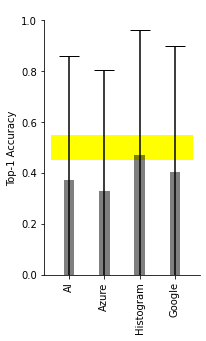

In [ ]:
#compute top 1 accuracy for each AI model and also overall AI
top1 = []
print(result_conf_mat)
for i in range(1+len(modelist)):
    #print(i)
    top1.append((result_conf_mat[0][0]+result_conf_mat[i+1][1])/2)
print(top1)

import matplotlib.pyplot as plt
import numpy as np

#data
#x-axis
years = list(range(1, 2+len(modelist)))
strtask = ['AI'] + modelist
#print(years)
#print(strtask)

# Figure Size
fig, ax = plt.subplots()

from matplotlib.patches import Rectangle
ax.add_patch(Rectangle((-0.5, 0.45), len(top1), 0.1,facecolor='yellow'))

#bar chart properties
# ax.bar(strtask, top1, color ='black', width = 0.3)
ax.bar(strtask, top1, yerr=all_stds.values(),
       align='center', alpha=0.5, ecolor='black', capsize=10,
       color ='black', width = 0.3)

plt.ylabel('Top-1 Accuracy')
plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees

plt.ylim(0, 1)
#plt.xlim(0.5, len(years)+0.5)

#draw chance 0.5
# chancex =np.arange(len(years))
# plt.plot(chancex, np.arange(len(chancex))*0+0.5, 'k--', label='chance (50%)')
#plt.legend()

fig.tight_layout()

fig.set_figwidth(2.5)
fig.set_figheight(5)

fig.legend(loc='upper center', bbox_to_anchor=(0.55, 1.0), ncol=3, fancybox=True, shadow=True,frameon=False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()
fig.savefig('figures/' + plotname + '_bert.pdf', bbox_inches='tight')